# Recording on Preston

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split

In [2]:
eeg_df = pd.read_csv("data/2018-10-12-preston_walk_raw.csv", skiprows=15)

In [3]:
eeg_df.head()

,Time,LE,F4,C4,PO8,PO7,C3,F3,Trigger,Time_Offset,ADC_Status,ADC_Sequence,Event,Comments
0,0.0033,3642.0,-2536.8,3530.1,2459.4,296.7,3454.5,-1103.4,0,6,0,207,0,Start Data Acquisition
1,0.0067,3635.7,-2526.3,3531.0,2451.9,299.7,3459.6,-1098.9,0,12,0,208,0,NaN
2,0.0100,3632.7,-2535.9,3528.6,2441.4,302.1,3454.8,-1103.4,0,18,0,209,0,NaN
3,0.0133,3626.7,-2535.3,3524.1,2450.1,297.9,3455.1,-1097.1,0,24,0,210,0,NaN
4,0.0167,3626.4,-2527.8,3539.4,2469.0,289.8,3452.7,-1089.9,0,30,0,211,0,NaN


## Filter data

In [4]:
from mne.filter import filter_data

In [5]:
channels = eeg_df.columns[1:8] 

In [6]:
eeg_data = eeg_df[channels].values

In [7]:
filtered = filter_data(eeg_data.T, sfreq=300, l_freq=1, h_freq=40)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 991 samples (3.303 sec) selected


In [8]:
eeg_df[channels] = filtered.T

## Epoch data

In [9]:
events = eeg_df.Event.nonzero()[0]

In [10]:
events

array([  1446,   2970,   7952,  47145,  78073, 135086])

In [11]:
walk_one_start = events[2] + 300
walk_one_stop = events[3] - 300
typing_start = events[3] + 300
typing_stop = events[4] - 300
talking_start = events[4] + 300  
talking_stop = events[5] - 300  
walk_two_start = events[5] + 300
walk_two_stop = len(eeg_df) - 9000

In [12]:
typing_data = eeg_df.loc[typing_start : typing_stop][channels]
talking_data = eeg_df.loc[talking_start : talking_stop][channels]
walk_one_data = eeg_df.loc[walk_one_start : walk_one_stop][channels]
walk_two_data = eeg_df.loc[walk_two_start : walk_two_stop][channels]

In [13]:
typing_data = typing_data[: len(typing_data) // 300 * 300]
talking_data = talking_data[: len(talking_data) // 300 * 300]
walk_one_data = walk_one_data[: len(walk_one_data) // 300 * 300]
walk_two_data = walk_two_data[: len(walk_two_data) // 300 * 300]
walk_data = np.concatenate((walk_one_data, walk_two_data), axis=0)

## Power, create data

In [14]:
other_data = np.concatenate((typing_data, talking_data), axis=0) 

In [18]:
f, t, spec = spectrogram(walk_data.T, fs=300, nperseg=600, noverlap=300)

In [19]:
walk_spec = spec[:, :81, :].reshape(-1, 218).T

In [20]:
f, t, spec = spectrogram(other_data.T, fs=300, nperseg=600, noverlap=300)

In [21]:
other_spec = spec[:, :81, :].reshape(-1, 288).T

In [22]:
X = np.concatenate((walk_spec, other_spec), axis=0)

In [23]:
y = np.concatenate((np.ones(len(walk_spec)), np.zeros(len(other_spec))), axis=0)

In [28]:
# shuffle data to get train/test
args = np.arange(len(X))
np.random.shuffle(args)
X = X[args]
y = y[args]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [36]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1)

## SVM, Hyperparameter tuning

In [31]:
from sklearn.svm import SVC

In [60]:
C = [0.001, 0.01, 0.1, 1, 5, 10]
gamma = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [61]:
train_score = []
dev_score = []

In [67]:
for c in C:
    for g in gamma:
        svc = SVC(kernel='poly', degree=g)
        svc.fit(X_train, y_train)
        train_score.append(svc.score(X_train, y_train))
        dev_score.append(svc.score(X_dev, y_dev))
        print("*", end='')
    print(".")

*******.
*******.
*******.
*******.
*******.
*******.


In [68]:
svc.predict(X_dev)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

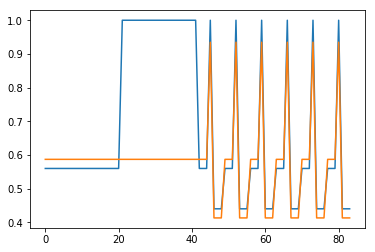

In [69]:
plt.plot(train_score)
plt.plot(dev_score)

In [58]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
svc.gamma

'auto'